# **Práctica Deep Learning**



Predicción del precio de las habitaciones de AirBnb con los **datos numéricos** disponibles del dataset airbnb, mediante:

*   Regresión
*   Clasificación



#### **Cargar las librerías y funciones necesarias**

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import tensorflow as tf
print(tf.__version__)

1.15.2


In [ ]:
# Cargamos librerías necesarias
import numpy  as np  
import pandas as pd

import matplotlib.pyplot as plt # para dibujar
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Tratamiento de imágenes
import imageio as io
import cv2

# Sets the value of the specified option
# Para visualizar la información de todas las filas pj dtypes o head().T aplico set_option en max_rows 
pd.set_option('display.max_rows', None)
# Para visualizar la información de la matriz de correlación
pd.set_option('display.max_columns', None)

In [ ]:
# Función que cambiar el orden de una columna
def change_column_order(df, col_name, index):
    cols = df.columns.tolist()
    cols.remove(col_name)
    cols.insert(index, col_name)
    return df[cols]

In [ ]:
# Función que realiza el preprocesado en train
def process_datasettrain(df):

	columns_1drop = ['Listing Url', 'Medium Url', 'Picture Url', 'XL Picture Url', 
					'Host URL', 'Host Thumbnail Url', 'Host Picture Url', 
					'ID', 'Scrape ID', 'Last Scraped', 'Calendar last Scraped', 'Weekly Price', 'Monthly Price',
					'Reviews per Month', 'Geolocation', 
					'Host ID', 'Host Name', 'Host Location', 'Host About', 'Host Neighbourhood',
					'Host Listings Count', 'Host Total Listings Count', 'Calculated host listings count']
	df.drop(columns_1drop, axis=1, inplace=True)  
	
	# Columnas a eliminar porque tiene un porcentaje superior al 90% de valores perdidos
	columns_2drop = ['Host Acceptance Rate', 'Square Feet', 'Has Availability', 'License', 'Jurisdiction Names']
	df.drop(columns_2drop, axis=1, inplace=True)  
	
	# Columnas a eliminar porque la información la podemos obtener de las variables Neighbourdhood, City y County Code
	columns_3drop = ['Street', 'State', 'Zipcode', 'Market', 'Smart Location', 'Country']
	df.drop(columns_3drop, axis=1, inplace=True)  

	# Filtro City  (alojamientos de Madrid)
	list_of_madrid = ['Madrid', 'Madrid, Comunidad de Madrid, ES', 'madrid', 'MADRID', 'las matas  madrid', 
					  'Boadilla del Monte', 'Delicias-Madrid', 'Delicias', 'Aravaca (Madrid)', 
					  'Chueca, Madrid', 'Madrid, Comunidad de Madrid, ESPANA']
	df_filtered = df[df['City'].isin(list_of_madrid)]
	# Aplicamos el filtro
	df = df[df['City'].isin(list_of_madrid)]

	# Filter Bathrooms 
	filter_bath0 = df['Bathrooms']!= 0
	df_filtered = df[filter_bath0]
	# Aplicamos el filtro
	df = df_filtered

	# Filter Price 
	filter_price = df['Price'] <= 250
	df_filtered = df[filter_price]
	# Aplicamos el filtro para Price
	df = df[filter_price]

	# Eliminamos los registros ausentes de la variable Thumbnail Url para trabajar con muestras con imágenes
	df.dropna(subset=['Thumbnail Url'], inplace=True)

	# Dataframe con las columnas desde Review Scores Rating hasta Review Scores Value 
	# para generar una nueva característica con la media de todas ellas
	df_review = df.loc[:,'Review Scores Rating':'Review Scores Value']
	df['Review Scores Mean'] = df_review.mean(axis=1)

	# Columnas a eliminar porque una alta correlación y esto origina valores redundantes
	columns_4drop = ['Accommodates', 'Availability 30', 'Availability 60', 'Availability 90',
					'Review Scores Accuracy', 'Review Scores Cleanliness', 'Review Scores Checkin',
					'Review Scores Communication', 'Review Scores Location', 
					'Review Scores Rating', 'Review Scores Value']
	df.drop(columns_4drop, axis=1, inplace=True) 

	# Columnas a eliminar 
	columns_6drop = ['Name', 'Summary', 'Space', 'Description', 'Notes', 'Transit', 'Access', 'Interaction', 
					'House Rules', 'Features']
	df.drop(columns_6drop, axis=1, inplace=True)  

	# Sustituimos los valores ausentes por la moda, es decir el valor que más se repite, en este caso within an hour
	df['Host Response Time'].fillna(df['Host Response Time'].mode()[0], inplace=True)
	# Sustituimos los valores ausentes por la moda, es decir el valor que más se repite, en este caso email,phone,reviews
	df['Host Verifications'].fillna(df['Host Verifications'].mode()[0], inplace=True)
	# Dataframe con la moda
	df_mode = pd.DataFrame({'variables': ['Host Response Time', 'Host Verifications'], 
                        'moda': [df['Host Response Time'].mode()[0], df['Host Verifications'].mode()[0]]})

	# Sustituimos los valores ausentes de la variable Neighbourhood por la variable Neighvourhood Group Cleansed
	df['Neighbourhood'].fillna(df['Neighbourhood Group Cleansed'], inplace=True)

	# En este caso decido sustituir los valores ausentes por "" para que en caso de tratar dicha variable la interpretación
	# sea más objetiva que con respecto al resto de alojamientos
	df['Amenities'].fillna("", inplace=True)

	# Columnas a eliminar según el análisis realizado
	columns_7drop = ['Experiences Offered', 'Neighborhood Overview', 'Neighbourhood Cleansed', 'Neighbourhood Group Cleansed',
					 'City', 'Country Code', 'First Review', 'Last Review', 'Host Since']
	df.drop(columns_7drop, axis=1, inplace=True)  

	# Creación de nuevas características a partir de las variables Host Verifications y Amenities
	# Ambas variables contienen información separada por coma, de manera que podemos contabilizar el nº de elementos
	# para así tenerlo en cuenta como una nueva característica para estas variables
	df['Host Verifications'] = df['Host Verifications'].apply(lambda x: len(str(x).split(',')))
	df['Amenities'] = df['Amenities'].apply(lambda x: len(str(x).split(',')))

	# categ_variables: list of variables to encode
	categ_variables = ['Host Response Time', 'Neighbourhood', 'Property Type', 'Room Type', 'Bed Type',
					   'Calendar Updated', 'Cancellation Policy']
	# mean_map: dict, mapping to be used on validation/test datasets
	mean_map=dict()  
	for v in categ_variables:
		mean_encode = df.groupby(v)['Price'].mean()
		df[v]=df[v].map(mean_encode)
		mean_map[v] = mean_encode

	# Columnas o variables aún con valores ausentes
	df.dropna(subset=['Property Type'], inplace=True)
	df.dropna(subset=['Calendar Updated'], inplace=True)

	# Columnas o variables aún con valores ausentes
	null_columns = df.columns[df.isnull().any()]
	# Data frame con la media para las columnas o variables con valores ausentes
	df_mean=dict()
	for v in null_columns:
		df_mean[v] = df[v].mean()
	
	# Sustituimos los valores ausentes por la media
	df.fillna(df.mean(), inplace = True)		
	
	return df, df_mode, mean_map, df_mean

In [ ]:
# Función que realiza el preprocesado en validation y test
def process_dataset(df, df_mode, mean_map, df_mean):

	columns_1drop = ['Listing Url', 'Medium Url', 'Picture Url', 'XL Picture Url', 
					'Host URL', 'Host Thumbnail Url', 'Host Picture Url', 
					'ID', 'Scrape ID', 'Last Scraped', 'Calendar last Scraped', 'Weekly Price', 'Monthly Price',
					'Reviews per Month', 'Geolocation', 
					'Host ID', 'Host Name', 'Host Location', 'Host About', 'Host Neighbourhood',
					'Host Listings Count', 'Host Total Listings Count', 'Calculated host listings count']
	df.drop(columns_1drop, axis=1, inplace=True)  

	# Columnas a eliminar porque tiene un porcentaje superior al 90% de valores perdidos
	columns_2drop = ['Host Acceptance Rate', 'Square Feet', 'Has Availability', 'License', 'Jurisdiction Names']
	df.drop(columns_2drop, axis=1, inplace=True)  

	# Columnas a eliminar porque la información la podemos obtener de las variables Neighbourdhood, City y County Code
	columns_3drop = ['Street', 'State', 'Zipcode', 'Market', 'Smart Location', 'Country']
	df.drop(columns_3drop, axis=1, inplace=True)  

	# Filtro City  (alojamientos de Madrid)
	list_of_madrid = ['Madrid', 'Madrid, Comunidad de Madrid, ES', 'madrid', 'MADRID', 'las matas  madrid', 
					  'Boadilla del Monte', 'Delicias-Madrid', 'Delicias', 'Aravaca (Madrid)', 
					  'Chueca, Madrid', 'Madrid, Comunidad de Madrid, ESPANA']
	df_filtered = df[df['City'].isin(list_of_madrid)]
	# Aplicamos el filtro
	df = df[df['City'].isin(list_of_madrid)]

	# Filter Bathrooms 
	filter_bath0 = df['Bathrooms']!= 0
	df_filtered = df[filter_bath0]
	# Aplicamos el filtro
	df = df_filtered

	# Filter Price 
	filter_price = df['Price'] <= 250
	df_filtered = df[filter_price]
	# Aplicamos el filtro para Price
	df = 	df[filter_price]

	# Eliminamos los registros ausentes de la variable Thumbnail Url para trabajar con muestras con imágenes
	df.dropna(subset=['Thumbnail Url'], inplace=True)

	# Dataframe con las columnas desde Review Scores Rating hasta Review Scores Value 
	# para generar una nueva característica con la media de todas ellas
	df_review = df.loc[:,'Review Scores Rating':'Review Scores Value']
	df['Review Scores Mean'] = df_review.mean(axis=1)

	# Columnas a eliminar porque una alta correlación y esto origina valores redundantes
	columns_4drop = ['Accommodates', 'Availability 30', 'Availability 60', 'Availability 90',
					'Review Scores Accuracy', 'Review Scores Cleanliness', 'Review Scores Checkin',
					'Review Scores Communication', 'Review Scores Location', 
					'Review Scores Rating', 'Review Scores Value']
	df.drop(columns_4drop, axis=1, inplace=True) 

	# Columnas a eliminar 
	columns_6drop = ['Name', 'Summary', 'Space', 'Description', 'Notes', 'Transit', 'Access', 'Interaction', 
					'House Rules', 'Features']
	df.drop(columns_6drop, axis=1, inplace=True)  

	# Sustituimos los valores ausentes por la moda, es decir el valor que más se repite, en este caso within an hour
	df['Host Response Time'].fillna(df_mode['moda'][0], inplace=True)
	# Sustituimos los valores ausentes por la moda, es decir el valor que más se repite, en este caso email,phone,reviews
	df['Host Verifications'].fillna(df_mode['moda'][1], inplace=True)

	# Sustituimos los valores ausentes de la variable Neighbourhood por la variable Neighvourhood Group Cleansed
	df['Neighbourhood'].fillna(df['Neighbourhood Group Cleansed'], inplace=True)

	# En este caso decido sustituir los valores ausentes por "" para que en caso de tratar dicha variable la interpretación
	# sea más objetiva que con respecto al resto de alojamientos
	df['Amenities'].fillna("", inplace=True)

	# Columnas a eliminar según el análisis realizado
	columns_7drop = ['Experiences Offered', 'Neighborhood Overview', 'Neighbourhood Cleansed', 'Neighbourhood Group Cleansed',
					 'City', 'Country Code', 'First Review', 'Last Review', 'Host Since']
	df.drop(columns_7drop, axis=1, inplace=True)  

	# Creación de nuevas características a partir de las variables Host Verifications y Amenities
	# Ambas variables contienen información separada por coma, de manera que podemos contabilizar el nº de elementos
	# para así tenerlo en cuenta como una nueva característica para estas variables
	df['Host Verifications'] = df['Host Verifications'].apply(lambda x: len(str(x).split(',')))
	df['Amenities'] = df['Amenities'].apply(lambda x: len(str(x).split(',')))

	# categ_variables: list of variables to encode
	categ_variables = ['Host Response Time', 'Neighbourhood', 'Property Type', 'Room Type', 'Bed Type',
					   'Calendar Updated', 'Cancellation Policy']
	# mean_map: dict, mapping to be used on validation/test datasets  
	for v in categ_variables:
		df[v]=df[v].map(mean_map[v])

	# Columnas o variables aún con valores ausentes
	df.dropna(subset=['Property Type'], inplace=True)
	df.dropna(subset=['Calendar Updated'], inplace=True)

	# Columnas o variables aún con valores ausentes
	null_columns = df.columns[df.isnull().any()]

	# Data frame con la media para las columnas o variables con valores ausentes
	for v in null_columns:
		df[v] = df_mean[v]

	return df

In [ ]:
# Función que separa el dataset en atributos y variable objetivo
from sklearn import preprocessing

def get_attributesdf(df):
  
  # Cambiamos la posición de la columna Price en la posición primera
  df = change_column_order(df, 'Price', 0)

  # convertimos el DataFrame al formato necesario para scikit-learn
  data = df.values

  y_data = data[:,0:1]     # nos quedamos con la 1ª columna, Price
  X_data = data[:,3:]      # nos quedamos con el resto salvo las columnas  Thumbnail Url 

  feature_names = df.columns[2:]

  return X_data, y_data

#### **Cargar Dataset airbnb**

In [ ]:
# Cargar el dataset externo desde OpenDataSoft con la URL
# https://public.opendatasoft.com/explore/dataset/airbnb-listings/download/?format=csv&disjunctive.host_verifications=true&disjunctive.amenities=true&disjunctive.features=true&q=Madrid&timezone=Europe/Berlin&lang=en&use_labels_for_header=true&csv_separator=%3B

!wget -O airbnb_listings.csv "https://public.opendatasoft.com/explore/dataset/airbnb-listings/download/?format=csv&disjunctive.host_verifications=true&disjunctive.amenities=true&disjunctive.features=true&q=Madrid&timezone=Europe/Berlin&lang=en&use_labels_for_header=true&csv_separator=%3B"


--2020-06-18 16:52:03--  https://public.opendatasoft.com/explore/dataset/airbnb-listings/download/?format=csv&disjunctive.host_verifications=true&disjunctive.amenities=true&disjunctive.features=true&q=Madrid&timezone=Europe/Berlin&lang=en&use_labels_for_header=true&csv_separator=%3B
Resolving public.opendatasoft.com (public.opendatasoft.com)... 34.249.199.226, 34.248.20.69
Connecting to public.opendatasoft.com (public.opendatasoft.com)|34.249.199.226|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/csv]
Saving to: ‘airbnb_listings.csv’

airbnb_listings.csv     [               <=>  ]  57.57M   457KB/s    in 2m 15s  

2020-06-18 16:54:24 (437 KB/s) - ‘airbnb_listings.csv’ saved [60364800]



In [ ]:
# Comprobar que tenemos el dataset descargado
!ls -lah /content/drive/My\ Drive/airbnb_listings.csv

-rw------- 1 root root 58M Jun 18 16:56 '/content/drive/My Drive/airbnb_listings.csv'


In [ ]:
# montamos GDrive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# almacenamos el dataset airbnb_listings.csv en nuestro drive
!cp airbnb_listings.csv /content/drive/My\ Drive/airbnb_listings.csv

In [ ]:
# Comprobar que tenemos el dataset airbnb descargado
!ls -lah /content/drive/My\ Drive/airbnb_listings.csv

-rw------- 1 root root 58M Jun 18 16:56 '/content/drive/My Drive/airbnb_listings.csv'


#### **División del dataset en train, validation y test**

Dividimos el dataframe df_airbnb_with_imgs en ttes conjuntos, uno para training (entrenamiento), otro para validation y un tercero para testing utizando:

    train_test_split = Split arrays or matrices into random train and test subsets con los parámetros:
      - shuffle = True   (orden aleatorio)
      - random_state = 0 (repetitibilidad de los datos) Using an int will produce the same results across different calls.
      - stratify = para estratificar la variable objetivo en el problema de clasificación.
      - test_size = Represent the proportion of the dataset df_train 75% to include in the test split.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import pandas as pd

# Read a dot comma-separated values (csv) file into DataFrame called df_airbnb
# pd invocar la librería de pandas con cabecera
df_airbnb = pd.read_csv('/content/drive/My Drive/airbnb_listings.csv', sep=';', decimal='.')   

print(f'Dimensiones del dataframe df_airbnb son: {df_airbnb.shape[0]} filas y {df_airbnb.shape[1]} columnas')

# Dividimos los datos del df en entrenamiento y test (2/3 training, 1/3 test) 
# random_state = repetitibidad de los datos
# shuffle by default is True --> orden aleatorio
airbnb_train, airbnb_test = train_test_split(df_airbnb, test_size=0.33, shuffle=True, random_state = 0)
print(f'Datos entrenamiento: {airbnb_train.shape}')
print(f'Datos test:  {airbnb_test.shape}')

# y despues volvemos a dividir training en validation (80% training, 20% validation)
airbnb_train, airbnb_val = train_test_split(airbnb_train, test_size=0.20, shuffle=True, random_state = 0)
print(f'Datos entrenamiento: {airbnb_train.shape}')
print(f'Datos validación:  {airbnb_val.shape}')

# Guardamos los conjuntos de training, validation y testing teniendo en cuenta una nueva columna que corresponde con el indice
#airbnb_train.to_csv('/content/drive/My Drive/airbnb_train.csv', sep=';', decimal='.', index=True)
#airbnb_val.to_csv('/content/drive/My Drive/airbnb_val.csv', sep=';', decimal='.', index=True)
#airbnb_test.to_csv('/content/drive/My Drive/airbnb_test.csv', sep=';', decimal='.', index=True)

# Lectura de dichos dataframes cuando los necesitemos
#airbnb_train = pd.read_csv('/content/drive/My Drive/airbnb_train.csv', sep=';', decimal='.')   
#airbnb_val   = pd.read_csv('/content/drive/My Drive/airbnb_val.csv',  sep=';', decimal='.')   
#airbnb_test  = pd.read_csv('/content/drive/My Drive/airbnb_test.csv', sep=';', decimal='.')   

Dimensiones del dataframe df_airbnb son: 14780 filas y 89 columnas
Datos entrenamiento: (9902, 89)
Datos test:  (4878, 89)
Datos entrenamiento: (7921, 89)
Datos validación:  (1981, 89)


In [ ]:
# Read a dot comma-separated values (csv) files
df_airbnb = pd.read_csv('/content/drive/My Drive/airbnb_listings.csv', sep=';', decimal='.')   
airbnb_train = pd.read_csv('/content/drive/My Drive/airbnb_train.csv', sep=';', decimal='.')   
airbnb_val   = pd.read_csv('/content/drive/My Drive/airbnb_val.csv',  sep=';', decimal='.')   
airbnb_test  = pd.read_csv('/content/drive/My Drive/airbnb_test.csv', sep=';', decimal='.')   

print(f'Dimensiones df_airbnb : {df_airbnb.shape}')
print(f'Datos entrenamiento: {airbnb_train.shape}')
print(f'Datos validación:  {airbnb_val.shape}')
print(f'Datos test:  {airbnb_test.shape}')

Dimensiones df_airbnb : (14780, 89)
Datos entrenamiento: (7921, 90)
Datos validación:  (1981, 90)
Datos test:  (4878, 90)


In [ ]:
# The column labels of the DataFrame df_airbnb
df_airbnb.columns

Index(['ID', 'Listing Url', 'Scrape ID', 'Last Scraped', 'Name', 'Summary',
       'Space', 'Description', 'Experiences Offered', 'Neighborhood Overview',
       'Notes', 'Transit', 'Access', 'Interaction', 'House Rules',
       'Thumbnail Url', 'Medium Url', 'Picture Url', 'XL Picture Url',
       'Host ID', 'Host URL', 'Host Name', 'Host Since', 'Host Location',
       'Host About', 'Host Response Time', 'Host Response Rate',
       'Host Acceptance Rate', 'Host Thumbnail Url', 'Host Picture Url',
       'Host Neighbourhood', 'Host Listings Count',
       'Host Total Listings Count', 'Host Verifications', 'Street',
       'Neighbourhood', 'Neighbourhood Cleansed',
       'Neighbourhood Group Cleansed', 'City', 'State', 'Zipcode', 'Market',
       'Smart Location', 'Country Code', 'Country', 'Latitude', 'Longitude',
       'Property Type', 'Room Type', 'Accommodates', 'Bathrooms', 'Bedrooms',
       'Beds', 'Bed Type', 'Amenities', 'Square Feet', 'Price', 'Weekly Price',
       'Month

In [ ]:
# Return the dtypes in the DataFrame df_airbnb
df_airbnb.dtypes

ID                                  int64
Listing Url                        object
Scrape ID                           int64
Last Scraped                       object
Name                               object
Summary                            object
Space                              object
Description                        object
Experiences Offered                object
Neighborhood Overview              object
Notes                              object
Transit                            object
Access                             object
Interaction                        object
House Rules                        object
Thumbnail Url                      object
Medium Url                         object
Picture Url                        object
XL Picture Url                     object
Host ID                             int64
Host URL                           object
Host Name                          object
Host Since                         object
Host Location                     

In [ ]:
# Visualizamos las primeras filas del dataset
df_airbnb.head(3)

,ID,Listing Url,Scrape ID,Last Scraped,Name,Summary,Space,Description,Experiences Offered,Neighborhood Overview,Notes,Transit,Access,Interaction,House Rules,Thumbnail Url,Medium Url,Picture Url,XL Picture Url,Host ID,Host URL,Host Name,Host Since,Host Location,Host About,Host Response Time,Host Response Rate,Host Acceptance Rate,Host Thumbnail Url,Host Picture Url,Host Neighbourhood,Host Listings Count,Host Total Listings Count,Host Verifications,Street,Neighbourhood,Neighbourhood Cleansed,Neighbourhood Group Cleansed,City,State,Zipcode,Market,Smart Location,Country Code,Country,Latitude,Longitude,Property Type,Room Type,Accommodates,Bathrooms,Bedrooms,Beds,Bed Type,Amenities,Square Feet,Price,Weekly Price,Monthly Price,Security Deposit,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Calendar Updated,Has Availability,Availability 30,Availability 60,Availability 90,Availability 365,Calendar last Scraped,Number of Reviews,First Review,Last Review,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,License,Jurisdiction Names,Cancellation Policy,Calculated host listings count,Reviews per Month,Geolocation,Features
0,12768616,https://www.airbnb.com/rooms/12768616,20170407214050,2017-04-08,Ramblas Studio D,"Unique apartment in vibrant neighborhoods, car...",Centrally located in the atmospheric Gothic Qu...,"Unique apartment in vibrant neighborhoods, car...",none,Located on the edge of the Gothic Quarter of B...,NaN,The nearest station is Place de Catalunya a fe...,NaN,NaN,No pets or smoking allowed.,https://a0.muscache.com/im/pictures/cffe393a-0...,https://a0.muscache.com/im/pictures/cffe393a-0...,https://public.opendatasoft.com/api/v2/catalog...,https://a0.muscache.com/im/pictures/cffe393a-0...,54310958,https://www.airbnb.com/users/show/54310958,Javier,2016-01-12,"Madrid, Community of Madrid, Spain",Be Mate offers the exclusive City Mate service...,within an hour,99.0,NaN,https://a0.muscache.com/im/pictures/8f3ec0f2-1...,https://a0.muscache.com/im/pictures/8f3ec0f2-1...,L'Antiga Esquerra de l'Eixample,207.0,207.0,"email,phone,reviews,jumio","El Gòtic, Barcelona, Catalunya 08002, Spain",El Gòtic,el Barri Gòtic,Ciutat Vella,Barcelona,Catalunya,08002,Barcelona,"Barcelona, Spain",ES,Spain,41.383887,2.171802,Apartment,Entire home/apt,2,1.0,0.0,1.0,Real Bed,"TV,Wireless Internet,Air conditioning,Kitchen,...",NaN,349.0,NaN,NaN,NaN,NaN,1,0,2,1125,a week ago,NaN,2,2,2,2,2017-04-08,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,strict,92.0,NaN,"41.3838872822,2.17180232785","Host Has Profile Pic,Host Identity Verified,Is..."
1,1629146,https://www.airbnb.com/rooms/1629146,20170407214050,2017-04-08,"Design, art & vintage / old city","If you're looking for a cool, spacious, light,...",The apartment is very comfortable and very tas...,"If you're looking for a cool, spacious, light,...",none,• A major advantage of this apartment is its l...,• Possibility of offering Premium Services suc...,• Nearest metro station is 1 min walk (Sant A...,Here's a list of of things we provide to our g...,==============================================...,* NO parties are allowed * NO noise on the st...,https://a0.muscache.com/im/pictures/ea919e56-a...,https://a0.muscache.com/im/pictures/ea919e56-a...,https://public.opendatasoft.com/api/v2/catalog...,https://a0.muscache.com/im/pictures/ea919e56-a...,8658841,https://www.airbnb.com/users/show/8658841,Olga & Co.,2013-09-05,"Barcelona, Catalonia, Spain","World traveller, currently living and working ...",within an hour,100.0,NaN,https://a0.muscache.com/im/pictures/d67fdad1-e...,https://a0.muscache.com/im/pictures/d67fdad1-e...,El Raval,2.0,2.0,"email,phone,reviews,jumio","El Raval, Barcelona, Catalonia 08001, Spain",El Raval,el Raval,Ciutat Vella,Barcelona,Catalonia,08001,Barcelona,"Barcelona, Spain",ES,Spain,41.382663,2.167558,Apartment,Entire home/apt,6,1.0,2.0,3.0,Real Bed,"TV,Internet,

#### Etiqueta de la variable objetivo

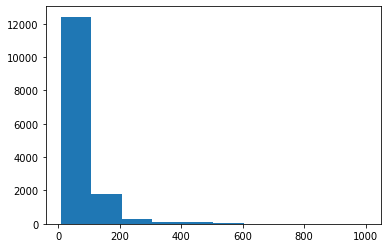

In [ ]:
# Etiqueta de la variable objetivo para el problema de regresión
y =df_airbnb['Price']

import matplotlib.pyplot as plt
plt.hist(y, bins=10)
plt.show()

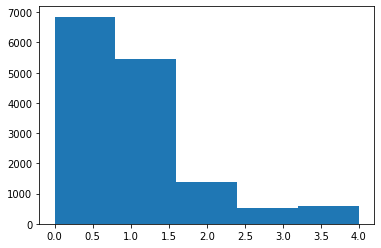

In [ ]:
# Etiqueta de la variable objetivo para el problema de clasificación
y = df_airbnb['Price']
y_class = []

for x in y:
    # La variable objetivo se asocia a 5 clases barato, medio, medio alto, caro y  muy caro
    if x <= 50:
        y_class.append(0)
    elif x <=100:
        y_class.append(1)
    elif x <=150:
        y_class.append(2)
    elif x <=200:
        y_class.append(3)
    else:
        y_class.append(4)

# y un rango para clasificación (del 1 al 5 por ejemplo: barato, medio, medio alto, caro y muy caro)
import matplotlib.pyplot as plt
plt.hist(y_class, bins=5)
plt.show()

#### **Preprocesado de los datos**

Se ha de tener en cuenta que todas las transformaciones que apliquemos en training se deben aplicar en validation y test

In [ ]:
# Renombramos la columna índice como Index
airbnb_train.rename(columns={'Unnamed: 0':'Index'}, inplace=True)
airbnb_val.rename(columns={'Unnamed: 0':'Index'}, inplace=True)
airbnb_test.rename(columns={'Unnamed: 0':'Index'}, inplace=True)

# Colocamos este nueva columna al final de los datasets
airbnb_train = change_column_order(airbnb_train, 'Index', 89)
airbnb_val = change_column_order(airbnb_val, 'Index', 89)
airbnb_test = change_column_order(airbnb_test, 'Index', 89)

In [ ]:
# Procesamos los datos del dataset de entrenamiento y una vez limpio lo guardamos para no reprocesar más
df_train, df_mode, mean_map, df_mean = process_datasettrain (airbnb_train)
print(f'Después del preprocesado - Datos entrenamiento: {df_train.shape}')
#df_train.to_csv('/content/drive/My Drive/airbnb_train_clean.csv', sep=';', decimal='.', index=True)

# Obtenemos los atributos del dataset de entrenamiento
X_train, y_train = get_attributesdf(df_train)

# Escalamos (con los datos de train)  - StandardScaler (x- media/desviación)
scaler = preprocessing.StandardScaler().fit(X_train)
XtrainScaled = scaler.transform(X_train)


Después del preprocesado - Datos entrenamiento: (5684, 27)


In [ ]:
# Procesamos los datos del dataset de validation y una vez limpio lo guardamos para no reprocesar más
df_val = process_dataset (airbnb_val, df_mode, mean_map, df_mean)
print(f'Después del preprocesado - Datos validation: {df_val.shape}')
#df_val.to_csv('/content/drive/My Drive/airbnb_val_clean.csv', sep=';', decimal='.', index=True)

# Obtenemos los atributos del dataset de validation
X_val, y_val = get_attributesdf(df_val)
# Escalamos (con los datos de train)  - StandardScaler (x- media/desviación)
XvalScaled = scaler.transform(X_val)

Después del preprocesado - Datos validation: (1396, 27)


In [ ]:
# Procesamos los datos del dataset de test y una vez limpio lo guardamos para no reprocesar más
df_test = process_dataset (airbnb_test, df_mode, mean_map, df_mean)
print(f'Después del preprocesado - Datos test: {df_test.shape}')
#df_test.to_csv('/content/drive/My Drive/airbnb_test_clean.csv', sep=';', decimal='.', index=True)

# Obtenemos los atributos del dataset de test
X_test, y_test = get_attributesdf(df_test)
# Escalamos (con los datos de train)  - StandardScaler (x- media/desviación)
XtestScaled = scaler.transform(X_test)

Después del preprocesado - Datos test: (3502, 27)


#### **Función que define la red MLP Multi-Layer Perceptron**

In [ ]:
# Función que define la red MLP Multi-Layer Perceptron
# parámetro regress = True para problema de regresión con función de activación linear (sin función de activación) y 1 neurona
# parámetro regress = False para problema de clasificación con función de activación softmax indicando 
# el nº de clases de la variable objetivo y este valor será el nº de neuronas 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def create_mlp(dim, regress):

	# define our MLP network
	model = Sequential()
	model.add(Dense(32, input_dim=dim, activation='relu'))
	model.add(Dense(18, activation='relu'))
	model.add(Dense(4, activation='relu'))
	# check to see if the regression node should be added with function activation linear
	# otherwise (classification) use softmax with the number of classes
	if regress:
		model.add(Dense(1, activation="linear"))
	else:
		model.add(Dense(5, activation="softmax"))  
  
	# return our model
	return model

#### **Regresión con datos numéricos**

In [ ]:
# import the necessary packages
from tensorflow.keras.optimizers import Adam
import numpy as np
import locale
import os

# find the largest house price in the training set and use it to
# scale our house prices to the range [0, 1] (this will lead to
# better training and convergence)
maxPrice = df_train['Price'].max()
y_train = df_train['Price'] / maxPrice
y_val = df_val['Price'] / maxPrice
y_test = df_test['Price'] / maxPrice

In [ ]:
# create our MLP and then compile the model using mean absolute
# percentage error as our loss, implying that we seek to minimize
# the absolute percentage difference between our price *predictions*
# and the *actual prices*
model = create_mlp(XtrainScaled.shape[1], regress=True)
opt = Adam(lr=1e-2, decay=1e-2/50)
model.compile(loss="mean_squared_error", optimizer=opt)

# train the model
print("[INFO] training model...")
history = model.fit(x=XtrainScaled, y=y_train, 
	        validation_data=(XvalScaled, y_val),
	        epochs=50, batch_size=16)

[INFO] training model...
Train on 5684 samples, validate on 1396 samples
Epoch 1/50
5684/5684 [==============================] - 1s 220us/sample - loss: 0.0140 - val_loss: 0.0145
Epoch 2/50
5684/5684 [==============================] - 1s 148us/sample - loss: 0.0082 - val_loss: 0.0142
Epoch 3/50
5684/5684 [==============================] - 1s 142us/sample - loss: 0.0075 - val_loss: 0.0133
Epoch 4/50
5684/5684 [==============================] - 1s 149us/sample - loss: 0.0074 - val_loss: 0.0144
Epoch 5/50
5684/5684 [==============================] - 1s 144us/sample - loss: 0.0073 - val_loss: 0.0134
Epoch 6/50
5684/5684 [==============================] - 1s 150us/sample - loss: 0.0071 - val_loss: 0.0143
Epoch 7/50
5684/5684 [==============================] - 1s 151us/sample - loss: 0.0068 - val_loss: 0.0137
Epoch 8/50
5684/5684 [==============================] - 1s 145us/sample - loss: 0.0069 - val_loss: 0.0140
Epoch 9/50
5684/5684 [==============================] - 1s 142us/sample - loss:

No conseguimos mejorar los resultados, aún modificando los valores de los hiperparámetros, learning_rate, batch_size.
Nos decantamos por los siguientes hiperparámetros opt = Adam(lr=1e-2, decay=1e-2/50) con un batch_size = 16 y con un entrenamiento de 50 épocas la función de costes disminuye en la muestra de train y en validación no conseguimos mejoría



```
Epoch 10/10 opt = Adam(lr=1e-3, decay=1e-3/50) 
5684/5684 [==============================] - 1s 262us/sample - loss: 0.0065 - val_loss: 0.0136 batch_size = 8
5684/5684 [==============================] - 1s 140us/sample - loss: 0.0072 - val_loss: 0.0150 batch_size = 16
5684/5684 [==============================] - 0s 75us/sample - loss: 0.0074 - val_loss: 0.0137 batch_size = 32

Epoch 10/10 opt = Adam(lr=1e-2, decay=1e-2/10)
5684/5684 [==============================] - 2s 285us/sample - loss: 0.0062 - val_loss: 0.0144 - batch_size = 8
5684/5684 [==============================] - 1s 141us/sample - loss: 0.0065 - val_loss: 0.0137 - batch_size = 16
5684/5684 [==============================] - 0s 69us/sample - loss: 0.0062 - val_loss: 0.0142 - batch_size = 32

Epoch 10/10 opt = Adam(lr=1e-1, decay=1e-1/10)
5684/5684 [==============================] - 1s 152us/sample - loss: 0.0249 - val_loss: 0.0251 - batch_size = 16
```
```
Epoch 50/50 opt = Adam(lr=1e-2, decay=1e-2/50) batch_size = 16
5684/5684 [==============================] - 1s 145us/sample - loss: 0.0041 - val_loss: 0.0141
```



Simplificamos el modelo MLP con una sola capa densa de 16 units




In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def create_mlp2(dim, regress):

	# define our MLP network
	model = Sequential()
	model.add(Dense(16, input_dim=dim, activation='relu'))

	# check to see if the regression node should be added with function activation linear
	# otherwise (classification) use softmax with the number of classes
	if regress:
		model.add(Dense(1, activation="linear"))
	else:
		model.add(Dense(5, activation="softmax"))  
  
	# return our model
	return model

In [ ]:
# create our MLP and then compile the model using mean absolute
# percentage error as our loss, implying that we seek to minimize
# the absolute percentage difference between our price *predictions*
# and the *actual prices*
model = create_mlp2(XtrainScaled.shape[1], regress=True)
opt = Adam(lr=1e-2, decay=1e-2/200)
model.compile(loss="mean_squared_error", optimizer=opt)

# train the model
print("[INFO] training model...")
history = model.fit(x=XtrainScaled, y=y_train, 
	        validation_data=(XvalScaled, y_val),
	        epochs=200, batch_size=16)

[INFO] training model...
Train on 5684 samples, validate on 1396 samples
Epoch 1/200
5684/5684 [==============================] - 1s 210us/sample - loss: 0.1010 - val_loss: 0.0192
Epoch 2/200
5684/5684 [==============================] - 1s 135us/sample - loss: 0.0138 - val_loss: 0.0173
Epoch 3/200
5684/5684 [==============================] - 1s 139us/sample - loss: 0.0169 - val_loss: 0.0138
Epoch 4/200
5684/5684 [==============================] - 1s 132us/sample - loss: 0.0130 - val_loss: 0.0199
Epoch 5/200
5684/5684 [==============================] - 1s 133us/sample - loss: 0.0304 - val_loss: 0.0185
Epoch 6/200
5684/5684 [==============================] - 1s 134us/sample - loss: 0.0208 - val_loss: 0.0159
Epoch 7/200
5684/5684 [==============================] - 1s 135us/sample - loss: 0.0086 - val_loss: 0.0145
Epoch 8/200
5684/5684 [==============================] - 1s 137us/sample - loss: 0.0082 - val_loss: 0.0136
Epoch 9/200
5684/5684 [==============================] - 1s 141us/sampl

Las funciones de costes han disminuido en la muestra de validación pero en train ha aumentado, con lo que no conseguimos mejorar el resultado. Probamos a entrenarlo 200 épocas y observamos que no adecuado.

```
Epoch 50/50 opt = Adam(lr=1e-2, decay=1e-2/50) batch_size = 16 Modelo con varias capas densas
5684/5684 [==============================] - 1s 145us/sample - loss: 0.0041 - val_loss: 0.0141

Epoch 50/50 opt = Adam(lr=1e-2, decay=1e-2/50) batch_size = 16 Modelo con 1 capa densa
5684/5684 [==============================] - 1s 125us/sample - loss: 0.0061 - val_loss: 0.0129
Epoch 200/200
5684/5684 [==============================] - 1s 136us/sample - loss: 0.0062 - val_loss: 0.0135
```



Como no conseguimos disminuir la función de costes, optamos por el primer modelo de red MLP y evaluamos sobre el conjunto de test

In [ ]:
# Evaluamos la función de perdidas
loss = model.evaluate(XtestScaled, y_test)
print(f'Loss={loss}')

3502/3502 [==============================] - 0s 38us/sample - loss: 0.0121
Loss=0.012102708265026857


In [ ]:
# make predictions on the testing data
print("[INFO] predicting house prices airbnb ...")
preds = model.predict(XtestScaled)

# compute the difference between the *predicted* house prices and the
# *actual* house prices, then compute the percentage difference and
# the absolute percentage difference
diff = preds.flatten() - y_test
percentDiff = (diff / y_test) * 100
absPercentDiff = np.abs(percentDiff)

# compute the mean and standard deviation of the absolute percentage
# difference
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)

# finally, show some statistics on our model
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("[INFO] avg. house price: {}, std house price: {}".format(
	locale.currency(df_airbnb['Price'].mean(), grouping=True),
	locale.currency(df_airbnb['Price'].std(), grouping=True)))
print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))

[INFO] predicting house prices airbnb ...
[INFO] avg. house price: $73.56, std house price: $72.06
[INFO] mean: 38.55%, std: 39.13%


Nuestro mean_squared_error final implica que, en promedio, nuestra red tendrá un ~ 39% de descuento en sus predicciones del precio de la vivienda con una desviación estándar de ~ 39%. 

#### **Clasificación con datos numéricos**

In [ ]:
# Función que categoriza la variable objetivo una vez clasificada en un rango de 5 clases
from keras.utils import to_categorical

def classes_price(df):

  y = df['Price']
  y_class = []

  for x in y:
      # La variable objetivo se asocia a 5 clases barato, medio, medio alto, caro y  muy caro
      if x <= 50:
          y_class.append(0)
      elif x <=100:
          y_class.append(1)
      elif x <=150:
          y_class.append(2)
      elif x <=200:
          y_class.append(3)
      else:
          y_class.append(4)
  
  y_class_onehot = to_categorical(y_class)

  return y_class_onehot

Using TensorFlow backend.


In [ ]:
# Obtenemos los atributos del dataset de entrenamiento
X_train, y_train = get_attributesdf(df_train)
y_train = classes_price(df_train)

# Escalamos (con los datos de train)  - StandardScaler (x- media/desviación)
scaler = preprocessing.StandardScaler().fit(X_train)
XtrainScaled = scaler.transform(X_train)

In [ ]:
# Obtenemos los atributos del dataset de validation
X_val, y_val = get_attributesdf(df_val)
y_val = classes_price(df_val)

# Escalamos (con los datos de train)  - StandardScaler (x- media/desviación)
XvalScaled = scaler.transform(X_val)

In [ ]:
# Obtenemos los atributos del dataset de test
X_test, y_test = get_attributesdf(df_test)
y_test = classes_price(df_test)

# Escalamos (con los datos de train)  - StandardScaler (x- media/desviación)
XtestScaled = scaler.transform(X_test)

In [ ]:
# import the necessary packages
from tensorflow.keras.optimizers import Adam
import numpy as np
import locale
import os

# Call to function MLP and then compile the model using categorical crossentropy as our loss, implying that we seek to minimize
# the accuracy difference between our price *predictions* and the *actual prices*  to classification problems
model = create_mlp(XtrainScaled.shape[1], False)
opt = Adam(lr=1e-1, decay=1e-1/50)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# train the model
print("[INFO] training model...")
history = model.fit(x=XtrainScaled, y=y_train, 
	        validation_data=(XvalScaled, y_val),
	        epochs=50, batch_size=16)

[INFO] training model...
Train on 5684 samples, validate on 1396 samples
Epoch 1/50
5684/5684 [==============================] - 1s 248us/sample - loss: 0.7823 - acc: 0.7088 - val_loss: 0.8086 - val_acc: 0.7056
Epoch 2/50
5684/5684 [==============================] - 1s 182us/sample - loss: 0.6792 - acc: 0.7430 - val_loss: 0.7986 - val_acc: 0.7235
Epoch 3/50
5684/5684 [==============================] - 1s 179us/sample - loss: 0.6567 - acc: 0.7465 - val_loss: 0.7407 - val_acc: 0.7285
Epoch 4/50
5684/5684 [==============================] - 1s 187us/sample - loss: 0.6208 - acc: 0.7519 - val_loss: 0.7400 - val_acc: 0.7135
Epoch 5/50
5684/5684 [==============================] - 1s 182us/sample - loss: 0.6158 - acc: 0.7546 - val_loss: 0.7477 - val_acc: 0.7249
Epoch 6/50
5684/5684 [==============================] - 1s 186us/sample - loss: 0.5901 - acc: 0.7671 - val_loss: 0.7598 - val_acc: 0.7113
Epoch 7/50
5684/5684 [==============================] - 1s 178us/sample - loss: 0.5807 - acc: 0.772

Con opt = Adam(lr=1e-3, decay=1e-3/50)  obtenemos un accuracy bastante bueno para train y validation aún variando el batch_size que oscilan de un 82.5 a 84.4 en train y entre un 71.6 y un 73 en validation.

Como el accuracy óptimo se ha alcanzado para un batch_size 16 o 64 vamos a probar a modificar el lr para estos valores de batch_size para determinar si conseguimos alguna mejora. 
```
Epoch 50/50

opt = Adam(lr=1e-3, decay=1e-3/50) 
5684/5684 [=======] - 2s 350us/sample - loss: 0.3958 - acc: 0.8399 - val_loss: 0.9396 - val_acc: 0.7163 - batch_size = 8
5684/5684 [=======] - 1s 179us/sample - loss: 0.4163 - acc: 0.8404 - val_loss: 0.9823 - val_acc: 0.7206 - batch_size = 16
5684/5684 [=======] - 0s 85us/sample - loss: 0.4201 - acc: 0.8378 - val_loss: 0.8805 - val_acc: 0.7221 - batch_size = 32
5684/5684 [=======] - 0s 45us/sample - loss: 0.4478 - acc: 0.8264 - val_loss: 0.8500 - val_acc: 0.730 - batch_size = 64

opt = Adam(lr=1e-2, decay=1e-2/50) 
5684/5684 [=======] - 1s 178us/sample - loss: 0.3263 - acc: 0.8749 - val_loss: 1.5419 - val_acc: 0.7106 - batch_size = 16
5684/5684 [=======] - 1s 92us/sample - loss: 0.3533 - acc: 0.8703 - val_loss: 0.9905 - val_acc: 0.7128 - batch_size = 32

opt = Adam(lr=1e-1, decay=1e-1/50) 
5684/5684 [=======] - 1s 184us/sample - loss: 0.4555 - acc: 0.8251 - val_loss: 0.9276 - val_acc: 0.7149 - batch_size = 16
5684/5684 [=======] - 1s 90us/sample - loss: 0.4951 - acc: 0.8207 - val_loss: 0.9301 - val_acc: 0.7070 - batch_size = 32
```



Tras las pruebas determinamos que los mejores resultados se alcanza con opt = Adam(lr=1e-2, decay=1e-2/50) y batch_size = 32 con un accuracy de 87% en train y 71% en validation, con lo que optamos por este modelo de red y entrenamos a 200 épocas para posteriormente evaluarlo en la muestra de test.

loss: 0.3533 - acc: 0.8703 - val_loss: 0.9905 - val_acc: 0.7128 - batch_size = 32


In [ ]:
# import the necessary packages
from tensorflow.keras.optimizers import Adam
import numpy as np
import locale
import os

# Call to function MLP and then compile the model using categorical crossentropy as our loss, implying that we seek to minimize
# the accuracy difference between our price *predictions* and the *actual prices*  to classification problems
model = create_mlp(XtrainScaled.shape[1], False)
opt = Adam(lr=1e-2, decay=1e-2/200)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# train the model
print("[INFO] training model...")
history = model.fit(x=XtrainScaled, y=y_train, 
	        validation_data=(XvalScaled, y_val),
	        epochs=200, batch_size=32)

[INFO] training model...
Train on 5684 samples, validate on 1396 samples
Epoch 1/200
5684/5684 [==============================] - 1s 158us/sample - loss: 0.7357 - acc: 0.7185 - val_loss: 0.7625 - val_acc: 0.7364
Epoch 2/200
5684/5684 [==============================] - 1s 91us/sample - loss: 0.5946 - acc: 0.7628 - val_loss: 0.8558 - val_acc: 0.7292
Epoch 3/200
5684/5684 [==============================] - 1s 93us/sample - loss: 0.5697 - acc: 0.7688 - val_loss: 0.8067 - val_acc: 0.7249
Epoch 4/200
5684/5684 [==============================] - 1s 91us/sample - loss: 0.5563 - acc: 0.7792 - val_loss: 0.8221 - val_acc: 0.7163
Epoch 5/200
5684/5684 [==============================] - 1s 94us/sample - loss: 0.5425 - acc: 0.7806 - val_loss: 0.8281 - val_acc: 0.7242
Epoch 6/200
5684/5684 [==============================] - 1s 91us/sample - loss: 0.5318 - acc: 0.7850 - val_loss: 0.9444 - val_acc: 0.7278
Epoch 7/200
5684/5684 [==============================] - 1s 93us/sample - loss: 0.5293 - acc: 0.78

Accuracy en train: 90.66%
Accuracy en valid: 70.77%

```
Epoch 200/200
5684/5684 [==============================] - 1s 94us/sample - loss: 0.2338 - acc: 0.9066 - val_loss: 2.9376 - val_acc: 0.7077
```



In [ ]:
# Evaluamos la función de perdidas
loss, accuracy = model.evaluate(XtestScaled, y_test)
print(f'Loss={loss}, Accuracy={accuracy}')

3502/3502 [==============================] - 0s 67us/sample - loss: 2.6494 - acc: 0.7327
Loss=2.6494181823008813, Accuracy=0.732724130153656


Nuestro accuracy es de un 73% en test con una función de pérdidas del 2.65,  diría que no es un mal resultado aunque con algo de overfitting.